# Problem 1

In [1]:
import torch
from torch import nn

In [2]:
def sigma(x):
    return torch.sigmoid(x)
def sigma_prime(x):
    return sigma(x)*(1-sigma(x))

In [3]:
torch.manual_seed(0)
L = 6
X_data = torch.rand(4, 1)
Y_data = torch.rand(1, 1)

A_list,b_list = [],[]
for _ in range(L-1):
    A_list.append(torch.rand(4, 4))
    b_list.append(torch.rand(4, 1))
A_list.append(torch.rand(1, 4))
b_list.append(torch.rand(1, 1))

# Option 1: directly use PyTorch's autograd feature
for A in A_list:
    A.requires_grad = True
for b in b_list:
    b.requires_grad = True
    
y = X_data
for ell in range(L):
    S = sigma if ell<L-1 else lambda x: x
    y = S(A_list[ell]@y+b_list[ell])
    
# backward pass in pytorch
loss=torch.square(y-Y_data)/2
loss.backward()

print(A_list[0].grad)
print(b_list[0].grad.T)

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])
tensor([[4.8247e-05, 6.8722e-05, 4.9245e-05, 4.0678e-05]])


In [4]:
torch.manual_seed(0)
L = 6
X_data = torch.rand(4, 1)
Y_data = torch.rand(1, 1)

A_list,b_list = [],[]
for _ in range(L-1):
    A_list.append(torch.rand(4, 4))
    b_list.append(torch.rand(4, 1))
A_list.append(torch.rand(1, 4))
b_list.append(torch.rand(1, 1))

# Option 2: construct a NN model and use backprop
class MLP(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.linear = nn.ModuleList([nn.Linear(4,4) for _ in range(L-1)])
        self.linear.append(nn.Linear(4,1))
        for ell in range(L):
            self.linear[ell].weight.data = A_list[ell]
            self.linear[ell].bias.data = b_list[ell].squeeze()
        
    def forward(self, x) :
        x = x.squeeze()
        for ell in range(L-1):
            x = sigma(self.linear[ell](x))
        x = self.linear[-1](x)
        return x

model = MLP()
            
loss = torch.square(model(X_data)-Y_data)/2
loss.backward()

print(model.linear[0].weight.grad)
print(model.linear[0].bias.grad)

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])
tensor([4.8247e-05, 6.8722e-05, 4.9245e-05, 4.0678e-05])


In [5]:
torch.manual_seed(0)
L = 6
X_data = torch.rand(4, 1)
Y_data = torch.rand(1, 1)

A_list,b_list = [],[]
for _ in range(L-1):
    A_list.append(torch.rand(4, 4))
    b_list.append(torch.rand(4, 1))
A_list.append(torch.rand(1, 4))
b_list.append(torch.rand(1, 1))

# Option 3: implement backprop yourself
y_list = [X_data]
y = X_data
for ell in range(L):
    S = sigma if ell<L-1 else lambda x: x
    y = S(A_list[ell]@y+b_list[ell])
    y_list.append(y)

dA_list = []
db_list = []
dy = y-Y_data               # dloss/dy_L
dyL = torch.tensor([[1.]])  # dy_L/dy_L
for ell in reversed(range(L)):
    S = sigma_prime if ell<L-1 else lambda x: torch.ones(x.shape)
    A, b, y = A_list[ell], b_list[ell], y_list[ell]

    db = dy@torch.diag(S(A@y+b).reshape(-1))                              # dloss/db_ell  
    dA = (y_list[-1]-Y_data)*torch.diag(S(A@y+b).reshape(-1))@dyL.T@y.T   # dloss/dA_ell
    dy = dy@torch.diag(S(A@y+b).reshape(-1))@A                            # dloss/dy_{ell-1}
    dyL = dyL@torch.diag(S(A@y+b).reshape(-1))@A                          # dy_L/dy_{ell-1}

    dA_list.insert(0, dA)
    db_list.insert(0, db)

print(dA_list[0])
print(db_list[0])

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])
tensor([[4.8247e-05, 6.8722e-05, 4.9245e-05, 4.0678e-05]])


Results from the three methods are identical.

# Problem 6

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import random

In [7]:
# MNIST dataset
mnist_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

train_dataset = Subset(mnist_dataset, torch.randperm(60000)[:6000])
train_dataset.targets = torch.randint(10, (len(train_dataset),))

In [8]:
# (Modified version of AlexNet)
class AlexNet(nn.Module):
    def __init__(self, num_class=10):
        super(AlexNet, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc_layer1 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(6400, 800),
            nn.ReLU(inplace=True),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = torch.flatten(output, 1)
        output = self.fc_layer1(output)
        return output

In [9]:
learning_rate = 0.1
batch_size = 64
epochs = 150

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

In [10]:
accuracy_list = []
loss_list = []

import time
tick = time.time()
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1} / {epochs}")

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = loss_function(model(images), labels)
        loss.backward()

        optimizer.step()
    
    train_loss, correct = 0, 0
    
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        train_loss += loss_function(output, labels).item()
        for i in range(len(output)):
            if torch.argmax(output[i]).item() == labels[i].item():
                correct += 1
    
    train_accuracy = correct / 6000

    accuracy_list.append(train_accuracy)
    loss_list.append(train_loss)

tock = time.time()
print(f"Total training time: {tock - tick}")


Epoch 1 / 150

Epoch 2 / 150

Epoch 3 / 150

Epoch 4 / 150

Epoch 5 / 150

Epoch 6 / 150

Epoch 7 / 150

Epoch 8 / 150

Epoch 9 / 150

Epoch 10 / 150

Epoch 11 / 150

Epoch 12 / 150

Epoch 13 / 150

Epoch 14 / 150

Epoch 15 / 150

Epoch 16 / 150

Epoch 17 / 150

Epoch 18 / 150

Epoch 19 / 150

Epoch 20 / 150

Epoch 21 / 150

Epoch 22 / 150

Epoch 23 / 150

Epoch 24 / 150

Epoch 25 / 150

Epoch 26 / 150

Epoch 27 / 150

Epoch 28 / 150

Epoch 29 / 150

Epoch 30 / 150

Epoch 31 / 150

Epoch 32 / 150

Epoch 33 / 150

Epoch 34 / 150

Epoch 35 / 150

Epoch 36 / 150

Epoch 37 / 150

Epoch 38 / 150

Epoch 39 / 150

Epoch 40 / 150

Epoch 41 / 150

Epoch 42 / 150

Epoch 43 / 150

Epoch 44 / 150

Epoch 45 / 150

Epoch 46 / 150

Epoch 47 / 150

Epoch 48 / 150

Epoch 49 / 150

Epoch 50 / 150

Epoch 51 / 150

Epoch 52 / 150

Epoch 53 / 150

Epoch 54 / 150

Epoch 55 / 150

Epoch 56 / 150

Epoch 57 / 150

Epoch 58 / 150

Epoch 59 / 150

Epoch 60 / 150

Epoch 61 / 150

Epoch 62 / 150

Epoch 63 / 150



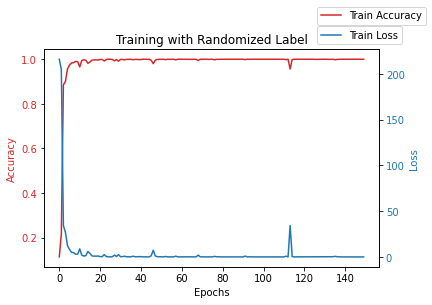

In [11]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='tab:red')
ax1.plot(range(epochs), accuracy_list, color='tab:red', label='Train Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(bbox_to_anchor=(0.8, 1.22), loc="upper left")
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:blue')
ax2.plot(range(epochs), loss_list, color='tab:blue', label='Train Loss')
ax2.tick_params(axis ='y', labelcolor='tab:blue')
ax2.legend(bbox_to_anchor=(0.8, 1.13), loc="upper left")
plt.title('Training with Randomized Label')
plt.show()